In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
import phate

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [5]:
inputs, class_labels, samples, snp_names, class_label_names = data_loader.load_data_1000G(os.path.join(exp_path, fname))
label_with_names, label_with_superpop_names = data_loader.preprocess_labels_1000G(class_labels, class_label_names)

In [8]:
1-((inputs.shape[0]*0.6)/inputs.shape[1]) #0.9925

0.9939422399624325

In [9]:
inputs.shape

(2322, 229986)

In [6]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

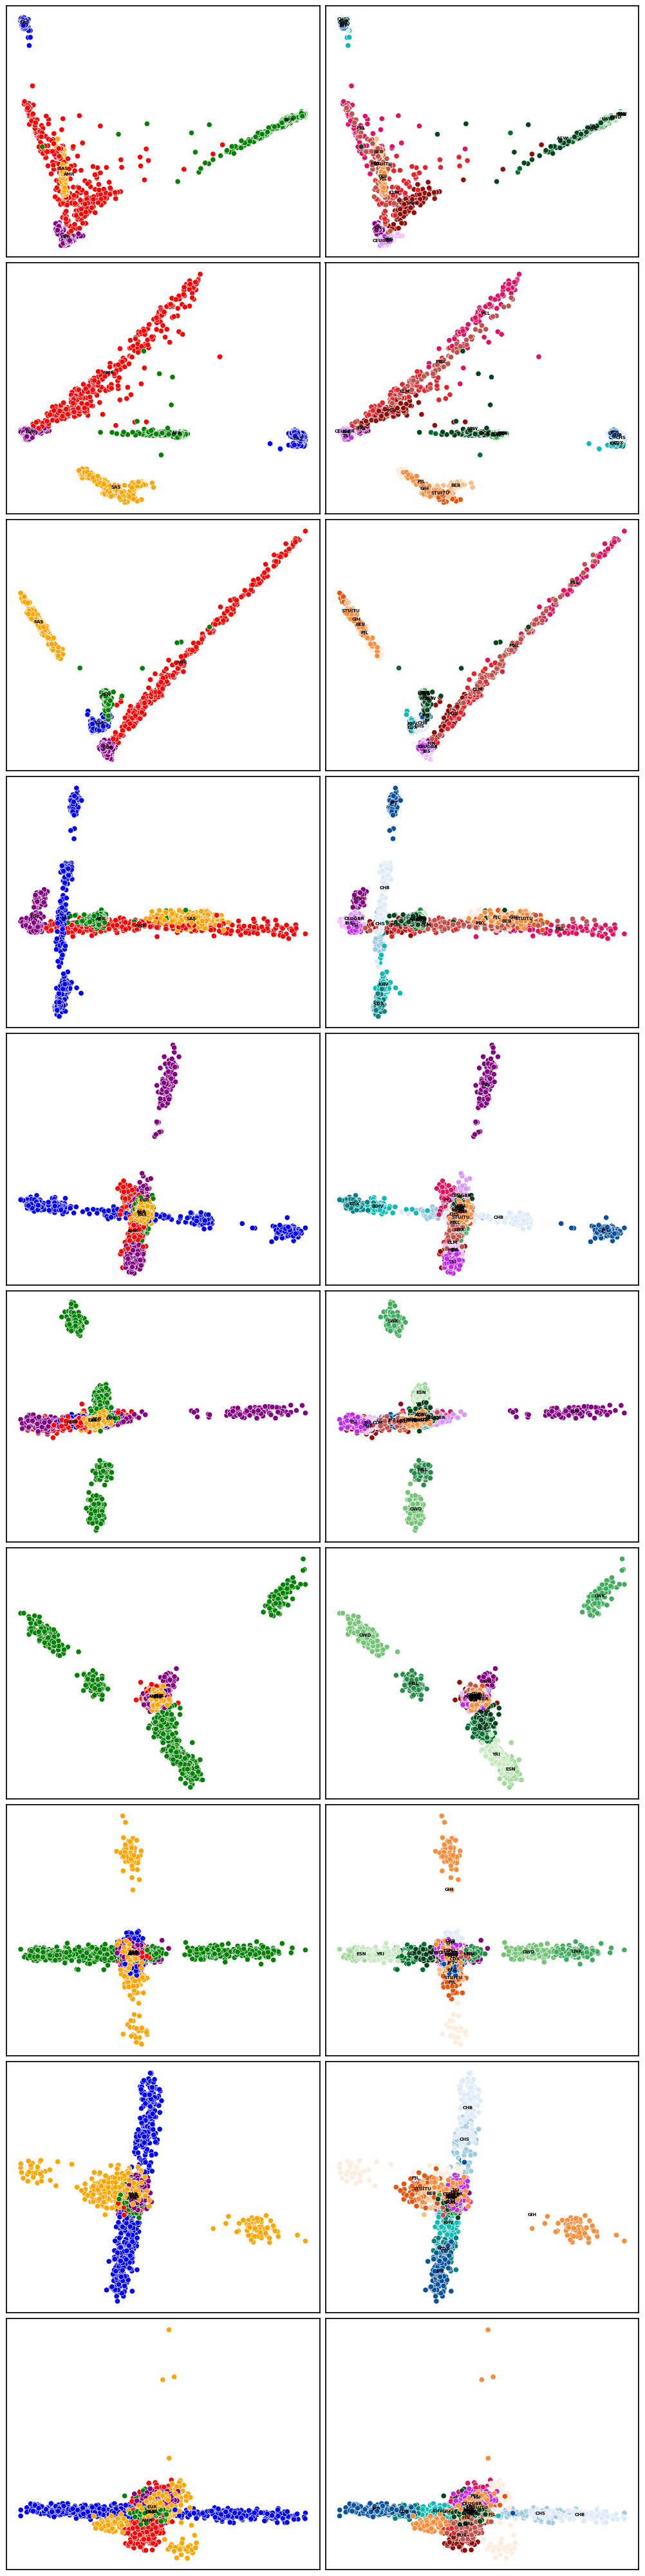

In [7]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,40))

for comp in range(10):
    # initial 2D phate embedding
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             label_with_superpop_names, 
                             None,
                             mappings.pop_pallette_1000G_coarse,
                             mappings.label_order_1000G_coarse,
                             True,
                             ax[comp, 0])
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             label_with_names,
                             None,
                             mappings.pop_pallette_1000G_fine,
                             mappings.label_order_1000G_fine,
                             True,
                             ax[comp, 1])
plt.tight_layout()

## Admix Ratios

In [8]:
def load_admix_ratio(sample_ids_path, admix_ratios_path, samples, labels):
    admix_labels = np.zeros([len(samples), 3])

    sample_ids = pd.read_csv(sample_ids_path, sep=' ', header=None)
    admix_ratios = pd.read_csv(admix_ratios_path, sep=' ', header=None)

    admix_df = pd.concat([admix_ratios, sample_ids], axis=1)
    admix_df.columns = ['admix 1', 'admix 2', 'admix 3' , 'sample id']

    matching_indices = np.array([np.where(admix_df['sample id'][j] == samples)[0][0] if len(np.where(admix_df['sample id'][j] == samples)[0]) > 0 else -1 for j in range(len(admix_df))])
    for i, idx in enumerate(matching_indices):
        if idx != -1:
            admix_labels[idx] = admix_df.iloc[i].values[:3]

    # color in all EUR or AFR individuals as 1
    admix_labels_inc_EURAFR = admix_labels
    admix_labels_inc_EURAFR[labels == 'EUR', 2] = 1
    admix_labels_inc_EURAFR[labels == 'AFR', 0] = 1

    return admix_labels, admix_labels_inc_EURAFR

In [9]:
data_path = '/lustre07/scratch/sciclun4/data/1000G/phate_genetics/MyAdmix'
sample_ids_path = os.path.join(data_path, 'output_ids.txt')
admix_ratios_path = os.path.join(data_path, 'AMR_ACB_ASW.3.Q')

admix_labels, admix_labels_inc_EURAFR = load_admix_ratio(sample_ids_path, 
                                                         admix_ratios_path,
                                                         samples,
                                                         class_labels)

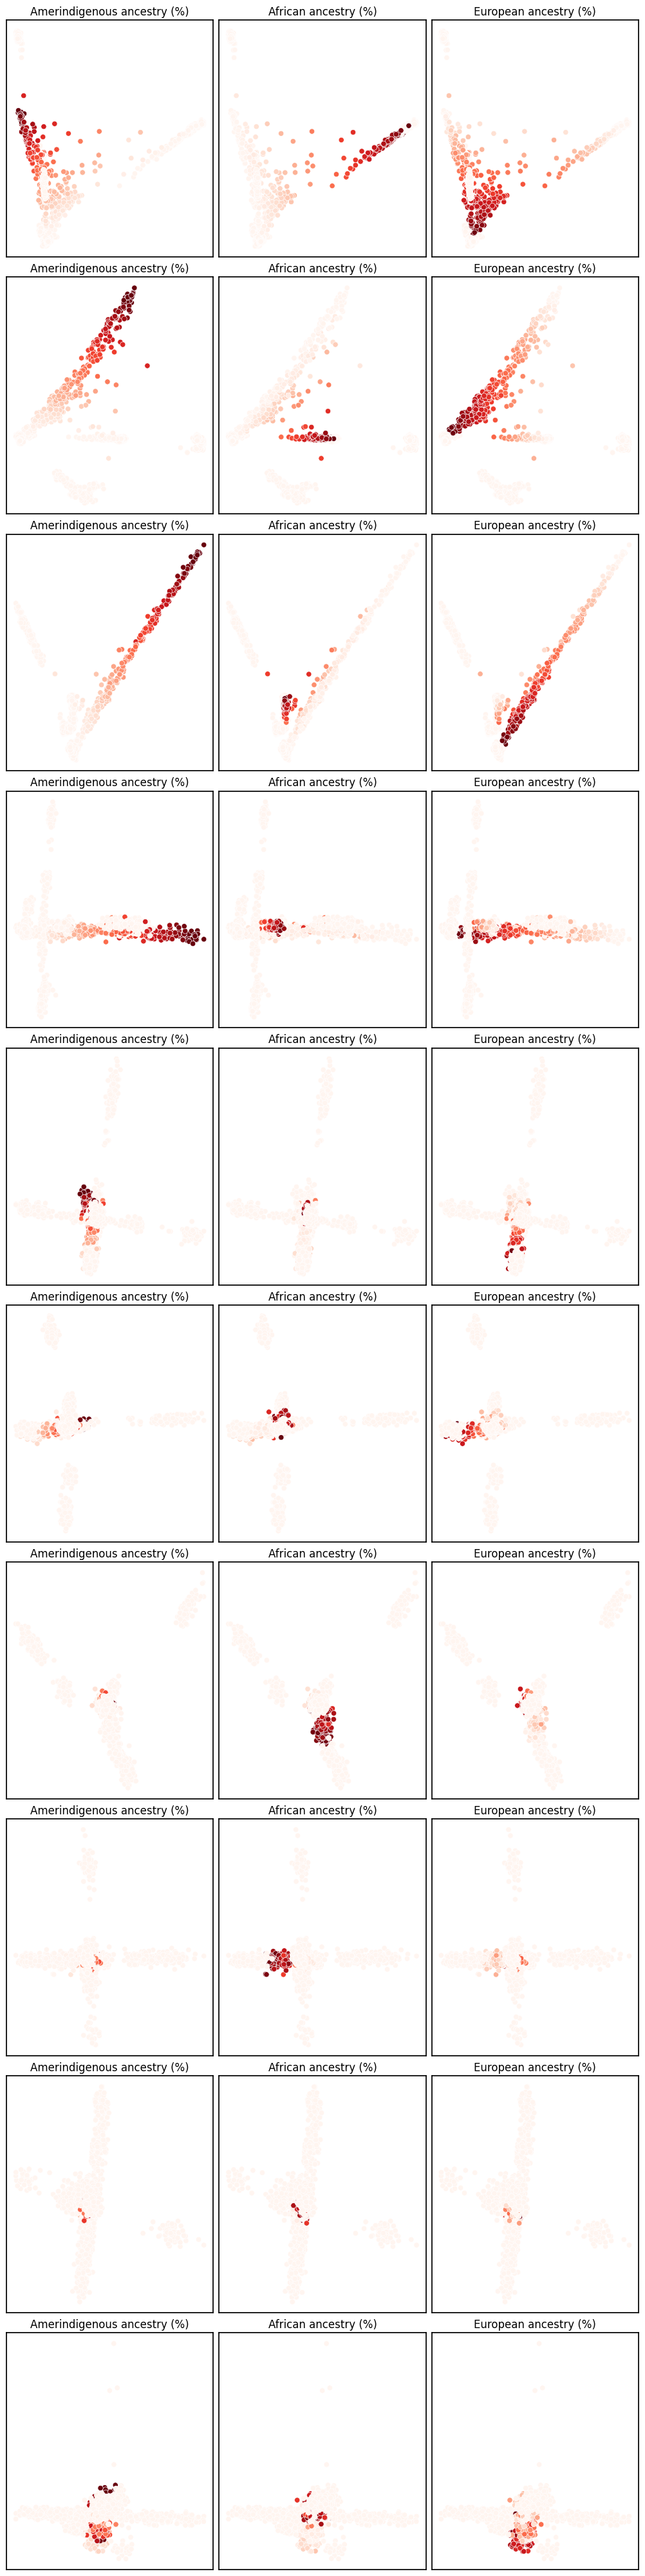

In [10]:
# initial 2D phate embedding
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(10,40))
    
for comp in range(10):
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             admix_labels_inc_EURAFR[:,1],
                             None,
                             None,
                             None,
                             True,
                             ax[comp, 0])
    ax[comp, 0].set_title("Amerindigenous ancestry (%)", fontsize=12)
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             admix_labels_inc_EURAFR[:,0],
                             None,
                             None,
                             None,
                             True,
                             ax[comp, 1])
    ax[comp, 1].set_title("African ancestry (%)", fontsize=12)
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             admix_labels_inc_EURAFR[:,2],
                             None,
                             None,
                             None,
                             True,
                             ax[comp, 2])
    ax[comp, 2].set_title("European ancestry (%)", fontsize=12)
plt.tight_layout()

## Admix Plot

In [16]:
admix_labels = np.zeros([len(samples), 3])

sample_ids = pd.read_csv(sample_ids_path, sep=' ', header=None)
admix_ratios = pd.read_csv(admix_ratios_path, sep=' ', header=None)

admix_df = pd.concat([admix_ratios, sample_ids], axis=1)
admix_df.columns = ['admix 1', 'admix 2', 'admix 3' , 'sample id']

matching_indices = np.array([np.where(admix_df['sample id'][j] == samples)[0][0] if len(np.where(admix_df['sample id'][j] == samples)[0]) > 0 else -1 for j in range(len(admix_df))])
for i, idx in enumerate(matching_indices):
    if idx != -1:
        admix_labels[idx] = admix_df.iloc[i].values[:3]

In [17]:
order = np.argsort(np.array(label_with_names)[matching_indices])
pop_label_names_admix = np.array(label_with_names)[matching_indices][order]
admix_ratios_ordered = admix_ratios.loc[order]

cutoffs = []
labels_ordered = np.unique(pop_label_names_admix)

for label in labels_ordered:
    cutoffs.append(np.where(label == pop_label_names_admix)[0].min())
cutoffs += [len(pop_label_names_admix)]

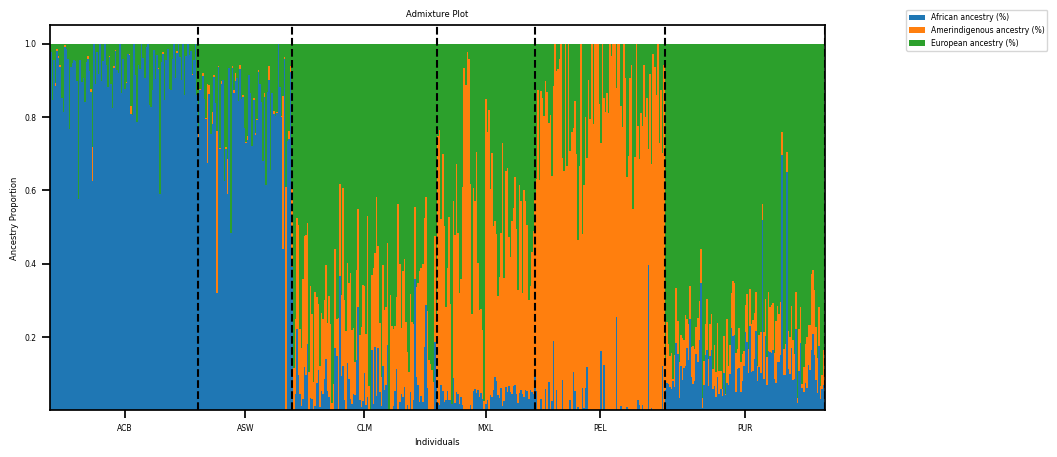

In [18]:
# Assuming each column in your CSV represents an ancestry component
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the size as needed

# Plot each population/ancestry component in a stacked manner
admix_ratios_ordered.plot(kind='bar', stacked=True, ax=ax, width=1.0, edgecolor='none')

# Optional: Customize the axes and layout
ax.set_xlabel('Individuals')
ax.set_ylabel('Ancestry Proportion')
ax.set_title('Admixture Plot')
#ax.get_xaxis().set_visible(False)
plt.xticks(rotation=0)  # Rotate the x-axis labels to horizontal
ax.legend(title='Populations')

ax.legend(bbox_to_anchor=(1.1, 1.05), 
          loc='upper left',
          labels=["African ancestry (%)",
                  "Amerindigenous ancestry (%)",
                  "European ancestry (%)"])

for i, pos in enumerate(cutoffs[1:]):
    ax.axvline(x=pos, linestyle='--', color='black')

plt.xticks(ticks=[(cutoffs[i]+cutoffs[i+1])/2 for i in range(len(cutoffs)-1)], labels=labels_ordered)

# Show the plot
plt.show()